# Generating new Objects w/ `Variational Auto Encoders (VAEs)`

### Import dependencies

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf

%matplotlib inline

### Load dataset

In [3]:
# from tensorflow.examples.tutorials.mnist import input_data

# data_dir = 'datasets/MNIST/'
# data = input_data.read_data_sets(data_dir, one_hot=True)

from dataset import ImageDataset

data_dir = 'datasets/101_ObjectCategories/'
save_file = 'saved/data.pkl'

data = ImageDataset(data_dir=data_dir, size=24, grayscale=True, flatten=True)
# data.create()
# data.save(save_file=save_file, force=True)
data = data.load(save_file=save_file)

102 of 102 labels	60 of 60 images....

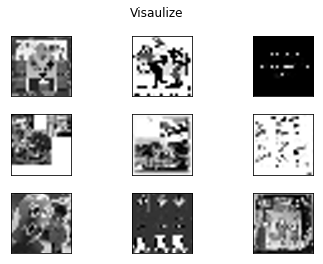

In [4]:
data.visualize(data.images[:9], name='Visaulize', smooth=True, cmap='gray')

### Hyperparameters

In [5]:
# Inputs
img_size = data.size  # 28
img_channel = data.channel  # 1
img_size_flat = img_size * img_size * img_channel
print(f'Images »»» Size: {img_size:,}\tChannel: {img_channel:,}\tFlattened: {img_size_flat:,}')

Images »»» Size: 24	Channel: 1	Flattened: 576


In [6]:
# Network
kernel_size = 4
stride      = 2
conv1_size  = 32
conv2_size  = 64
hidden_size = 256
latent_size = 128
fc1_size    = 256
fc2_size    = 64
keep_prob   = 0.8

In [7]:
# Training
batch_size    = 24
learning_rate = .01
save_interval = 100
log_interval  = 1000
iterations    = 10000

### Helpers

In [8]:
# import matplotlib.pyplot as plt

# def visualize(imgs, name=None, smooth=False, **kwargs):
#     # Plot images in grid
#     grid = int(np.sqrt(len(imgs)))
#     # Create figure with sub-plots.
#     fig, axes = plt.subplots(grid, grid)
#     fig.subplots_adjust(hspace=0.3, wspace=0.3)

#     for i, ax in enumerate(axes.flat):
#         # Interpolation type.
#         interpolation = 'spline16' if smooth else 'nearest'
#         shape = [img_size, img_size]
#         ax.imshow(imgs[i].reshape(shape), interpolation=interpolation, **kwargs)
#         # Remove ticks from the plot.
#         ax.set_xticks([])
#         ax.set_yticks([])
#     if name:
#         plt.suptitle(name)
#     plt.show()

In [9]:
def lrelu(x, alpha=0.2):
    return tf.maximum(x, tf.multiply(x, alpha))

In [11]:
def encoder(image, is_training=False):
    with tf.name_scope('encoder'):
        net = tf.reshape(image, [-1, img_size, img_size, img_channel])
        net = tf.contrib.layers.conv2d(net, conv1_size, kernel_size=kernel_size, stride=stride, activation_fn=lrelu)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training)
        net = tf.contrib.layers.conv2d(net, conv1_size, kernel_size=kernel_size, stride=stride, activation_fn=lrelu)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training)
        net = tf.contrib.layers.flatten(net)
        net = tf.contrib.layers.fully_connected(net, hidden_size, activation_fn=lrelu)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training)
        mean = tf.contrib.layers.fully_connected(net, latent_size, activation_fn=None)
        stddev = 0.5 * tf.contrib.layers.fully_connected(net, latent_size, activation_fn=None)
        noise = tf.random_normal(shape=[1, latent_size])
        # encoded = mean + tf.multiply(noise, tf.exp(0.5 * stddev))
        encoded = mean + (stddev * noise)
        return encoded, mean, stddev

In [12]:
def decoder(encoded, is_training=False):
    with tf.name_scope('decoder'):
        net = tf.contrib.layers.fully_connected(encoded, latent_size, activation_fn=lrelu)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training)
        net = tf.contrib.layers.fully_connected(net, hidden_size, activation_fn=lrelu)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training)
        net = tf.contrib.layers.fully_connected(net, fc1_size, activation_fn=lrelu)
        net = tf.contrib.layers.fully_connected(net, fc2_size, activation_fn=lrelu)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training)
        net = tf.contrib.layers.fully_connected(net, img_size_flat, activation_fn=tf.nn.sigmoid)
        img = tf.reshape(net, [-1, img_size, img_size, img_channel])
        return net, img

In [13]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, img_size_flat])

In [14]:
encoded, mean, stddev = encoder(X, is_training=True)
decoded, d_img = decoder(encoded)

### Loss function

In [15]:
rec_loss = tf.reduce_sum(tf.squared_difference(X, decoded), reduction_indices=1)
# kl_term = -0.5 * tf.reduce_sum(1.0 + 2.0 * stddev - tf.square(mean) - tf.exp(2.0 * stddev), reduction_indices=1)
kl_term = 0.5 * tf.reduce_sum(tf.square(mean) + tf.square(stddev) - tf.log(tf.square(stddev)) -1, reduction_indices=1)
loss = tf.reduce_mean(rec_loss + kl_term)

### Optimizer

In [16]:
global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss, global_step=global_step)

## Running the computational graph

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### Tensoboard

In [18]:
tensorboard_dir = 'tensorboard/generate/vae/'
logdir = os.path.join(tensorboard_dir, 'log')
save_path = 'models/generate/vae/'
save_model = os.path.join(save_path, 'model.ckpt')

tf.summary.histogram('rec_loss', rec_loss)
tf.summary.histogram('kl_term', kl_term)
tf.summary.scalar('rec_loss_mean', tf.reduce_mean(rec_loss))
tf.summary.scalar('kl_term_mean', tf.reduce_mean(kl_term))
tf.summary.scalar('loss', loss)
tf.summary.image('decoded', d_img, max_outputs=6)
merged = tf.summary.merge_all()

saver = tf.train.Saver()
writer = tf.summary.FileWriter(logdir=logdir, graph=sess.graph)

In [19]:
if tf.gfile.Exists(save_path):
    try:
        sys.stdout.write('INFO: Attempting to restore last checkpoint.\n')
        last_ckpt = tf.train.latest_checkpoint(save_path)
        saver.restore(sess=sess, save_path=last_ckpt)
        sys.stdout.write(f'INFO: Restored last checkpoint from {last_ckpt}\n')
        sys.stdout.flush()
    except Exception as e:
        sys.stderr.write(f'ERR: Could not restore checkpoint. {e}')
        sys.stderr.flush()
else:
    tf.gfile.MakeDirs(save_path)
    sys.stdout.write(f'INFO: Created checkpoint directory: {save_path}\n')
    sys.stdout.flush()

INFO: Created checkpoint directory: models/generate/vae/


### Training

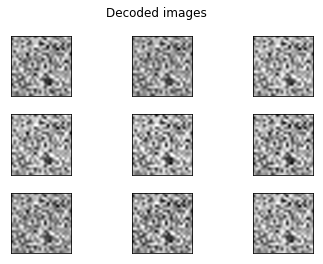

Iter: 1,000	Global: 1,000	Loss: 11765523.0	Time: 0:00:46.534143

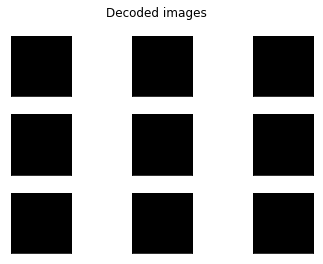

Iter: 2,000	Global: 2,000	Loss: 14216589.0	Time: 0:01:32.536465

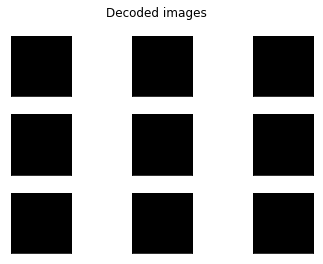

Iter: 3,000	Global: 3,000	Loss: 14269171.0	Time: 0:02:15.671922

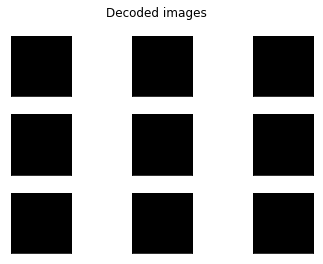

Iter: 3,603	Global: 3,603	Loss: 13935864.0	Time: 0:02:51.463322

In [ ]:
start_time = dt.datetime.now()

for i in range(iterations):
    X_batch = data.next_batch(batch_size=batch_size)[0]
    _, _loss, _i_global = sess.run([train, loss, global_step], feed_dict={X: X_batch})
    if i%save_interval == 0:
        saver.save(sess=sess, save_path=save_model, global_step=global_step)
        summary = sess.run(merged, feed_dict={X: X_batch})
        writer.add_summary(summary=summary, global_step=_i_global)
    if i%log_interval == 0:
        randoms = [np.random.normal(0, 1, latent_size) for _ in range(9)]
        imgs = sess.run(decoded, feed_dict={encoded: randoms})
        data.visualize(imgs, name='Decoded images', smooth=True, cmap='gray')
        # visualize(imgs, name='Decoded images', smooth=True, cmap='Greys')
    sys.stdout.write(f'\rIter: {i+1:,}\tGlobal: {_i_global:,}\tLoss: {_loss}\t'
                     f'Time: {dt.datetime.now() - start_time}')
    sys.stdout.flush()